In [126]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

# Deutsch-Jozsa Algorithm

In this tutorial we introduce one of the first quantum algorithm’s developed by pioneers David Deutsch and Richard Jozsa. This algorithm showcases an efficient quantum solution to a problem that cannot be solved classically but instead can be solved using a quantum device.   

**The goal of this tutorial to:**

1. Give an introduction to quantum algorithms
2. Implement the Deutsch-Jozsa algorithm on a hardware device 
3. Gain a deeper understanding of how this algorithm works and why quantum is advantageous over a classical analog. 

We make the assumption that the user is comfortable with the Python programming language, linear algebra and has some background knowledge about quantum computing. It is not necessary to have a physics background to understand this tutorial but if you’d like to dive deeper, some resources will be linked at the end of the tutorial. 
## Overview 
1. [Introduction to quantum algorithms](#quantum_algo) 
2. [Deutsch's problem](#deutsch_problem)
3. [Technical background for Deustch-Jozsa Algorithm](#technical) 
4. [Circuit setup](#setup) 
5. [Code](#setup)  
6. [Summary, next steps and resources](#summary)

<a id="quantum_algo"></a>

## Quantum Algorithms
Quantum algorithms is an area of research closely tied to quantum computing. We develop quantum algorithms that can natively be implemented on a quantum device, usually in the form of creating quantum circuits. Just like classical circuits, quantum circuits allow for implementation of algorithms in a set of instructions usually in the form of gates that can manipulate the state of the qubit (quantum bit). Quantum algorithms take advantage of the natural quantum mechanical properties like superposition and entanglement and are inherently quantum in nature. These algorithms allow us to solve problems that cannot be attempted classically, such as the Deutsch-Jozsa Algorithm. 

<a id="deutsch_problem"></a>

## Deutsch's Problem 
The algorithm proposed is solving a black box problem, trying to determine what the black box is the task at hand. The problem itself is not very applicable in real life but showcases an occasion where a quantum algorithm performs exponentially better than a classical one. 

Let $Uf$ be an oracle (black box) that computes a Boolean function which only takes binary inputs (0’s or 1’s). These functions can be represented as $f: {0, 1}^n →  {0, 1}$. This oracle evaluates two types of functions, constant or balanced. 

A constant function takes any input and returns only 0’s or only 1’s and a balanced function takes any input and returns exactly half 0’s and half 1’s. 

**Constant:** 011010 → $Uf$ → 000000  
**Balanced:** 000011 → $Uf$ → 111000

The goal is to determine what type of function is $Uf$ based on only the outputs. If the input is as large as $2^n$ then the amount of queries a classical computer will have to make is $2n/2+1$. We can see for a large enough n this problem scales exponentially and becomes inefficient to solve classically. However, leveraging a quantum algorithm we only need to query the oracle once to determine the type of function for $Uf$. This is possible because the state of its output might be in a coherent superposition of states corresponding to different answers, each which solves the problem (Deutsch 1992). 


<a id="technical"></a>

## Technical Background for Deutsch-Jozsa Algorithm

*If you are a unfamiliar with quantum mechanics, feel free to skip this section and go straight to the circuit setup.* 

To build the algorithm we first prepare our qubits according to our input, the input state prepares n-qubits in the $|0〉$state for query register and an extra qubit as the answer register prepared in the $|1〉$ 

$$|ψ_0〉 = |0〉^{⊗n}|1〉$$

The Hadamard gate is applied to the query and answer register, this puts the qubits into a superposition state

$$|ψ_1〉 = ∑_{x∈{0,1}^n} \frac{|x〉}{√2^n} \biggl[\frac{ |0〉 − |1〉}{√2}\biggr]$$

The query register is in a superposition of all possible values and the answer register is in a superposition of 0 and 1. The next step is to evaluate function $f$ for the oracle $Uf$ for the inputs $∣x,y〉→∣x,y⊕f(x)〉$giving you an output of

$$ |ψ_2〉 =∑_x\frac{(-1)^{f(x)}|x〉}{√2^n}\biggl[\frac{ |0〉 − |1〉}{√2}\biggr]$$

The evaluation of the function is stored in the amplitude of the qubit in superposition state. We apply Hadamard gates to the query register to interfere and essentially remove the qubits from their superposition state. The effect of the Hadamard gates on the n-qubits can be summarized as follows

$$ H^{⊕n}|x〉= \frac{∑_z(-1)^{x\cdot{z}}|z〉}{√2^n}$$

where $x⋅z$ is the bitwise inner product of $x$ and $z$, modulo 2. We can calculate the state as

$$|ψ_3〉=∑_z∑_x\frac{(-1)^{x\cdot{z} + f(x)}|z〉}{2^n}\biggl[\frac{ |0〉 − |1〉}{√2}\biggr]$$

We can now measure and observe the results for the possible functions. For the two possible cases, if the function is constant then the measurement will observe all 0’s, if the function is balanced then you will observe a mix of 1's and 0's and if you have both measurements present for a function the it's neither constant or balanced. 

*Reference: Nielsen & Chuang*


In [127]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time
import numpy as np
import random
from scipy.linalg import expm

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

<a id="setup"></a>

## Circuit setup 

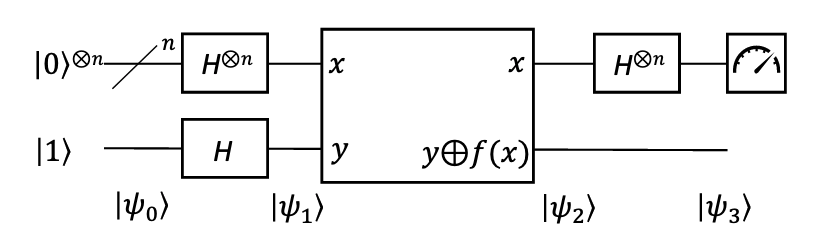

## 1. Setting up our qubits

We begin by first setting up our qubits, these are represented by the lines or “wires” on the diagram above. We can separate our qubits into two registers. 

The first register is our n-qubits initalized to the basis state of $∣0⟩$. The number of qubits initialized to state $∣0⟩$ is determined by how many bits long our input is. So if our input is 2 bits long then we would use two qubits in our first register.

For the second register we initialize one qubit to state $∣1⟩$ by applying the X gate. 



## 2. Apply Hadamard gates

Now for both our qubit registers we apply a Hadamard gate. The H-gate is a transformation that takes a qubit at a ground state like $∣0⟩$ or $∣1⟩$ and puts it into a superposition of 0 and 1. 

For example, if you have a coin you only have two sides, either heads or tails. Now imagine if you apply some force to this coin and balance it on its thin side, now its neither head or tails but in a superposition of both possible sides. A Hadamard gate is like this force or transformation that puts a qubit into superposition of 0 and 1.

The first register is now in a superposition of all possible input values and the second register is in a superposition of 0 and 1. 

In [128]:
# function to initialize the input qubits and output qubit

def init_states(n_qubits): 
    
    # define the output qubit
    output_qubit = n_qubits 
    
    # create circuit and initialize states
    circuit = Circuit().h(range(n_qubits)).x(output_qubit).h(output_qubit)
    
    return circuit

In [129]:
# example circuit initializition for 3 qubits 
n_qubits = 3
init = init_states(n_qubits)
print(init)

T  : |0|1|
          
q0 : -H---
          
q1 : -H---
          
q2 : -H---
          
q3 : -X-H-

T  : |0|1|


---------------------------------------------------------------------------------------------------------------------
## 3. Apply the oracle

The oracle is the Boolean function that is applied to the n-qubits in the query register. 

You can create this oracle using a unitary matrix which allows us to store the answer to the Boolean function in the amplitude of a qubit in the superposition state. A unitary operation allows any function $f(x)$ to be encoded on a quantum computer using specific quantum gates. 

There are many different ways to implement this oracle because we can create constant or balanced functions using different combinations of gate operations. To showcase this, we've created a random oracle that can will either implement a constant oracle, balanced oracle or none using a random assortment of x, cnot and ccnot gates. 

The I and X gates are single qubit gates, they only perform on one qubit. The I gate is an “identity-gate” which essentially does nothing, it leaves the qubit as is. The X gate switches the amplitudes of the states $∣0⟩$ and $∣1⟩$. The CNOT gate is a two qubit gate, it is used to entangle two qubits in superposition together, it takes in control qubit and decides based on that if it needs to flip the spin of the target qubit. 

## For a constant function: 
1. if $f(x) = 0$, then apply the I gate to the qubit in second register.  
2. if $f(x) = 1$, then apply the X gate to the qubit in second register.  

In [130]:
# function to create a constant oracle 

def constant_oracle(n_qubits):
    
    # define the output qubit 
    output_qubit = n_qubits 
    
    # create circuit 
    circuit = Circuit()
    
    # set output to either 0 or 1 
    rand_output = np.random.randint(0, 2)
    
    # if output qubit is 0, apply i gate to not change value 
    if rand_output == 0:
        circuit.i(output_qubit)
    # if output is 1, apply x gate to change value to 0 
    if rand_output == 1: 
        circuit.x(output_qubit)
    
    return circuit

In [131]:
# example circuit for constant oracle 
n_qubits = 5
constant = constant_oracle(n_qubits)
print(const) 

T  : |0|
        
q5 : -I-

T  : |0|


---------------------------------------------------------------------------------------------------------------------
## For a balanced function:

Apply a CNOT gate to every qubit in the first register and set the qubit in the second register as the target. Use a random number generator to randomly choose which qubits to add an X - gate before and after the CNOT gate.

In [132]:
# function to create a balanced oracle 

def balanced_oracle(n_qubits): 
    
    # define the output qubit 
    output_qubit = n_qubits 
    
    # create circuit 
    circuit = Circuit()
    
    # generate a random array of 0s and 1s to figure out where to place x gates
    random_num = np.random.randint(2, size=n_qubits)
    
    # place x gates 
    for qubit in range(len(random_num)):
        if random_num[qubit] == 1:
            circuit.x(qubit)        
    
    # place cnot gates
    for qubit in range(n_qubits):
        circuit.cnot(control=qubit, target=output_qubit)
    
    # place x gates    
    for qubit in range(len(random_num)): 
        if random_num[qubit] == 1:
            circuit.x(qubit)
        
    return circuit

In [133]:
# example circuit for balanced oracle
n_qubits = 10
balanced = balanced_oracle(n_qubits)
print(bal)

T   : | 0 |1|2|3|4|5|6|7|8|9|
                             
q0  : ---C-------------------
         |                   
q1  : ---|-C-----------------
         | |                 
q2  : ---|-|-C---------------
         | | |               
q3  : -X-|-|-|-C-X-----------
         | | | |             
q4  : -X-|-|-|-|-C-X---------
         | | | | |           
q5  : ---|-|-|-|-|-C---------
         | | | | | |         
q6  : ---|-|-|-|-|-|-C-------
         | | | | | | |       
q7  : ---|-|-|-|-|-|-|-C-----
         | | | | | | | |     
q8  : ---|-|-|-|-|-|-|-|-C---
         | | | | | | | | |   
q9  : ---|-|-|-|-|-|-|-|-|-C-
         | | | | | | | | | | 
q10 : ---X-X-X-X-X-X-X-X-X-X-

T   : | 0 |1|2|3|4|5|6|7|8|9|


---------------------------------------------------------------------------------------------------------------------

## For a random function:

We have created a random oracle generator to showcase the many different ways a constant or balanced oracle can be made using just X, CNOT and CCNOT gates. When running this function, you can have 3 different outcomes. Either a constant function, a balanced function or neither. 

We create a list of different types of gates you can apply, the X gate a single gate and CNOT and CCNOT require multiple gates. The CCNOT is a 3 qubit gate, it's similar to CNOT except you have 2 control qubits and 1 target qubit. 

We randomly choose which type of gates to apply and then randomly apply gates on different qubits to see what kind of function has been created. 

In [141]:
def random_oracle(n_qubits): 
    
    # create circuit 
    circuit = Circuit()
    
    # define the output qubit 
    output_qubit = n_qubits 
    
    # create a random array of 0s and 1s to determine where to place the gates
    random_array = np.random.randint(2, size=n_qubits)
    
    # define the single gate set 
    single_gate_set = "x"
    
    # define the multiple qubit gate set
    multiple_gate_set = ["cnot", "ccnot"]
    
    # create a list combining single and multiple qubit gates to randomly choose from
    choice_gate_set = ["single_gate_set", "multiple_gate_set"]
    
    # random oracle circuit generator
    
    # implement all the gate options 
    for qubit in range(len(random_array)):
        
        # randomly choose to apply a single qubit or multiple qubit gate 
        random_gate_set = np.random.choice(choice_gate_set, p=[0.30, 0.70])
        
        # if single qubit gate then implement x gate accordingly 
        if random_gate_set == "single_gate_set": 
            if random_array[qubit] == 1:
                circuit.x(qubit)
        
        # if multiple qubit gate then implement cnot and ccnot gates 
        if random_gate_set == "multiple_gate_set": 
            
            # randomly choose to implement a cnot or ccnot gate
            random_gate_m = np.random.choice(multiple_gate_set)
            if random_gate_m == "cnot":
                if random_array[qubit] == 0:
                    #randomly choose where the target qubit is
                    targetf = np.random.randint(n_qubits+1)
                    if qubit!= targetf:
                        circuit.cnot(control=qubit, target=targetf)
                else: 
                    #randomly choose where the target qubit is
                    targetf = np.random.randint(n_qubits+1)
                    circuit.x(qubit)
                    if qubit!= targetf:
                        circuit.cnot(control=qubit, target=targetf)
                    circuit.x(qubit) 
            if random_gate_m == "ccnot":
                #randomly choose where the first and second controls are
                control1 = np.random.randint(n_qubits+1)
                control2 = np.random.randint(n_qubits+1)
                #randomly choose where the target qubit is
                targetf = np.random.randint(n_qubits+1)
                if control1 != control2 and control1 != targetf and control2 != targetf:
                    circuit.ccnot(control1, control2, targetf) 
    
    return circuit

In [142]:
n_qubits = 4 
random = random_oracle(n_qubits)
print(random)

T  : |0|1|
          
q0 : -C---
      |   
q1 : -C---
      |   
q2 : -X-X-

T  : |0|1|


## 4. Apply Hadamard gate to first qubit register

After applying the quantum oracle a H-gate is applied to all the qubits in the first register. This is because applying the H-gate again takes the qubits out of a superposition state. 

If the function was constant then the quantum state after the H-gate is applied should be the same as it’s initial state. This is because, if there are three qubits in the first register, then the initial quantum state looks as follows after the first set of H-gates have acted on it:

$$\frac{1}{\sqrt{8}} \times \begin{bmatrix} 1\\ 1\\ 1\\ 1\\ 1\\ 1\\ 1\\ 1\\ \end{bmatrix}$$

But if the Boolean function returns all zeros or, alternatively, all ones then the state vector becomes equal to the left and right state vectors, respectively, as shown below:

$$\frac{1}{\sqrt{8}} \times \begin{bmatrix} 1\\ 1\\ 1\\ 1\\ 1\\ 1\\ 1\\ 1\\ \end{bmatrix}, \frac{1}{\sqrt{8}} \times \begin{bmatrix} -1\\ -1\\ -1\\ -1\\ -1\\ -1\\ -1\\ -1\\ \end{bmatrix}$$

This means that when the Boolean function is constant, the state vector either remains the same or acquires a global phase, which in both cases results in the system returning back to its initial state.

If the function is balanced a negative phase is added to exactly half the quantum states which can be seen in the following example state vector:

$$\frac{1}{\sqrt{8}} \times \begin{bmatrix} 1\\ -1\\ 1\\ -1\\ 1\\ -1\\ 1\\ -1\\ \end{bmatrix}$$

This can be easily shown to be orthogonal to the original state vector by projecting the resulting state vector onto the original state vector:

$$\frac{1}{\sqrt{8}}\times \begin{bmatrix} 1 & -1 & 1 & -1 & 1 & -1 & 1 & -1 \end{bmatrix} \times \frac{1}{\sqrt{8}} \times \begin{bmatrix} 1\\ 1\\ 1\\ 1\\ 1\\ 1\\ 1\\ 1\\ \end{bmatrix}=0$$

which means that the resulting state vector is completely orthogonal to the original state vector and the resulting state vector will be anything but ∣000⟩ after the final set of H-gates are applied.

Meanwhile, if the Boolean function is neither constant or balanced, then the resulting state vector becomes similar to the following:

$$\frac{1}{\sqrt{8}}\times \begin{bmatrix} 1\\ 1\\ 1\\ 1\\ 1\\ -1\\ 1\\ -1\\ \end{bmatrix}$$

which can be easily seen to be neither zero or one when this state is projected onto the original state. This means that the resulting output (after the final set of H-gates have been applied) will be a combination of the ∣000⟩ state and an orthogonal state.

**Note:** You have to keep in mind that in addition to the qubits in the first register, there is also the additional output qubit. This additional output qubit is not used for determining the classification of this Boolean function (constant, balanced, or neither) using this setup. 

In [136]:
# general deutsch-jozsa algorithm 

def dj_algorithm(oracle, n_qubits):
    
    # define the output qubit 
    output_qubit = n_qubits 
    
    # create circuit and initialize states
    circuit = Circuit().h(range(n_qubits)).x(output_qubit).h(output_qubit)
    
    # add the oracle circuit 
    circuit.add_circuit(oracle, range(n_qubits + output_qubit))
    
    # place the h-gates again
    circuit.h(range(n_qubits))
    
    # measure the results
    for qubit in range(n_qubits):
        circuit.sample(observable=Observable.Z(), target=qubit)
    
    Shots = 100
    #Designate the device being used as the local simulator, feel free to use another device
    device = LocalSimulator()
    #Submit the task
    my_task = device.run(circuit, shots=Shots)
    #Retrieve the result
    result = my_task.result()
    #print the measurement probabilities
    print('Measurement results:\n',result.measurement_probabilities) 
    
    return circuit

In [137]:
n_qubits = 4
# randomly choose the type of oracle to implement in your algorithm
dj_algo = dj_algorithm(np.random.choice([constant, balanced, random]), n_qubits)
print(dj_algo)

Measurement results:
 {'00000000001': 0.17, '11111000000': 0.06, '11110000001': 0.08, '11110000000': 0.17, '00000000000': 0.13, '00001000001': 0.11, '11111000001': 0.11, '00001000000': 0.17}
T   : |0| 1 | 2 |3|4|5|6|7|8|9|10|Result Types|
                                             
q0  : -H---C-H--------------------Sample(Z)----
           |                                 
q1  : -H-X-|---C-X-H--------------Sample(Z)----
           |   |                             
q2  : -H-X-|---|-C-X-H------------Sample(Z)----
           |   | |                           
q3  : -H---|---|-|-C-H------------Sample(Z)----
           |   | | |                         
q4  : -X-H-|-X-|-|-|-C-X-----------------------
           |   | | | |                       
q5  : -X---|---|-|-|-|-C-X---------------------
           |   | | | | |                     
q6  : -----|---|-|-|-|-|-C---------------------
           |   | | | | | |                   
q7  : -----|---|-|-|-|-|-|-C-------------------
         

## Classicaly Run the Random Circuit Generator 

The function classical_generator takes a random oracle and applies it to $2^n-1$ possible combinations where n is the number of qubits you've initialized. We can create a classical circuit by removing the Hadamard gates because without putting any qubits in superposition, the circuit can't display quantum mechanical properties. 

If n = 3 then we get a result of 8 different circuits. We then determine if these circuits are constant, balanced or neither at the end so we can compare it with results when we run this circuit but this time on a quantum circuit.

#### *To generate a new random circuit run the random_oracle function again!*

In [143]:
# run initialized states through circuit and add random_oracle 
def classical_generator(n_qubits, random_oracle):
    
    # define the output qubit 
    output_qubit = n_qubits 

    n = n_qubits
    
    matrix = []
    
    for i in range(0, 2**n):
        # convert integer to bitstring and into an integer
        bit_str = [int(x) for x in str(format(i, "b"))]
        # if len of bitstring less than n then pad with zeros
        if len(bit_str) < n:
            num_zero = n - len(bit_str)
            bit_str = np.pad(bit_str, (num_zero, 0), 'constant')
        # append bit_str to matrix 
        matrix.append(bit_str)
    
    # turn matix into an numpy array
    matrix_bitout = np.array(matrix)
    
    measurement_results_classical = []
    
    for row in matrix_bitout:
        circuit = Circuit()
        #retrieve the bit string that initializes the qubits for this iteration
        qubit_info = row.tolist()
        print(qubit_info) 
        # creating initial states of our classical circuit
        for qubit in range(len(qubit_info)):
            if qubit_info[qubit] == 1:
                circuit.x(qubit)
            else: 
                circuit.i(qubit)
        # adding random circuit to our initial states 
        circuit.add_circuit(random_oracle, range(n_qubits))
        circuit.sample(observable=Observable.Z(), target=output_qubit)
        print(circuit)
        
        Shots = 1
        #Designate the device being used as the local simulator, feel free to use another device
        device = LocalSimulator()
        #Submit the task
        my_task = device.run(circuit, shots=Shots)
        
        #Retrieve the result
        result = my_task.result()
        #print the measurement probabilities
        print('Measurement results:\n',result.measurement_probabilities)
        del circuit
        
        # store results in a measurement variable 
        measurement_classical = result.measurement_probabilities
        for k, v in measurement_classical.items(): 
            int(k)
        measurement_list = (list(k))
        measurement_results_classical.append(measurement_list)
        # classical checker circuits 
        classical_results = np.array(measurement_results_classical)
        final_rc = []
        for row in classical_results: 
            result = int(row[-1])
            final_rc.append(result)
    
        total_rc = len(final_rc)
        count_0 = 0
        count_1 = 0
    
        for val in final_rc:
            if val == 0: 
                count_0 += 1
            if val == 1:
                count_1 += 1
    
    if total_rc == count_0: 
        print("This is a constant function")
    
    elif count_0 == total_rc/2 and count_1 == total_rc/2: 
            print("This is a balanced function")
    else:
        print("This is neither a constant nor balanced function")
         
     
    print("These are the final outputs from the random circuits", final_rc)
    return random_oracle

In [144]:
n_qubits = 3
run_circuit = classical_generator(n_qubits, random)

[0, 0, 0]
T  : |0|1|2|Result Types|
                       
q0 : -I-C----------------
        |              
q1 : -I-C----------------
        |              
q2 : -I-X-X--------------
                       
q3 : -------Sample(Z)----

T  : |0|1|2|Result Types|
Measurement results:
 {'0010': 1.0}
[0, 0, 1]
T  : |0|1|2|Result Types|
                       
q0 : -I-C----------------
        |              
q1 : -I-C----------------
        |              
q2 : -X-X-X--------------
                       
q3 : -------Sample(Z)----

T  : |0|1|2|Result Types|
Measurement results:
 {'0000': 1.0}
[0, 1, 0]
T  : |0|1|2|Result Types|
                       
q0 : -I-C----------------
        |              
q1 : -X-C----------------
        |              
q2 : -I-X-X--------------
                       
q3 : -------Sample(Z)----

T  : |0|1|2|Result Types|
Measurement results:
 {'0110': 1.0}
[0, 1, 1]
T  : |0|1|2|Result Types|
                       
q0 : -I-C----------------
        |        

## Run Random Circuit Generator on Quantum Circuit

Now we can run the random circuit we generated classically on a quantum circuit to compare and see if the results are the same. We measure the results and based on the output we can determine what type of function the random circuit was.

In [145]:
def random_oracle(n_qubits, random_oracle):
    # create circuit 
    circuit2 = Circuit()
    
    # define the output qubit 
    output_qubit = n_qubits 
    
    # create circuit and initialize states
    circuit2 = Circuit().h(range(n_qubits)).x(output_qubit).h(output_qubit)
    #add the random oracle to this circuit
    circuit2.add_circuit(random_oracle, range(n_qubits))
    # place the h-gates again
    circuit2.h(range(n_qubits))
    
    measurement_results_quantum = []
    
    # measure the results
    for qubit in range(n_qubits):
        circuit2.sample(observable=Observable.Z(), target=qubit)
    print(circuit2)
    Shots = 100
    #Designate the device being used as the local simulator
    #Feel free to use another device
    device = LocalSimulator()
    #Submit the task
    my_task2 = device.run(circuit2, shots=Shots)
    #Retrieve the result
    result2 = my_task2.result()
    measurement_quantum = result2.measurement_probabilities
    #print the measurement probabilities
    print('Measurement results:\n',result2.measurement_probabilities)
    
    measurement_keys = []
    for k, v in measurement_quantum.items():
        measurement_keys.append(list(k))
    quantum_results = np.array(measurement_keys)
    final_rq = []
    all_measurements = []
    for row in quantum_results:
        func = []
        for val in row[:-1]:
            func.append(int(val))
        all_measurements.append(func)
    
    num_outputs = len(all_measurements)
    
    type_func = 0
    
    for row in all_measurements:
        if sum(row) == 0: 
            type_func += 0
        else: 
            type_func += 1

    if type_func == 0: 
        print("This is a constant function")
    elif type_func == num_outputs: 
        print("This is a balanced function")
    else: 
        print("This is neither a balanced or constant function")

In [146]:
n_qubits = 3 
oracle = random_oracle(n_qubits,run_circuit)

T  : |0|1|2|3|Result Types|
                         
q0 : -H-C-H---Sample(Z)----
        |                
q1 : -H-C-H---Sample(Z)----
        |                
q2 : -H-X-X-H-Sample(Z)----
                         
q3 : -X-H------------------

T  : |0|1|2|3|Result Types|
Measurement results:
 {'0001': 0.53, '0000': 0.47}
This is a constant function


<a id="summary"></a>

## Comparing the Classical and Quantum Results

Once you've run the classical and quantum version of the random circuit you can compare the results. If both correspond to the same type of function then we have found another to implement the constant or balanced function! 

You can keep generating more random circuits to see how the constant and balanced functions can be created including for circuits that are extremely large, example 10 qubits! 

## Next Steps 

This was an introduction to one of the first quantum computing algorithms implemented as a circuit. The goal of this tutorial is to give an in-depth explantion on how quantum algorithms are developed, where we achieve computational speedup and how to create your own version of the Deutsch-Jozsa aglorithm. 

**Here are some resources to dive deeper:**  
[Introduction to quantum computing using Qiskit](https://qiskit.org/textbook/ch-states/introduction.html)  

[Introduction to quantum computing TED Talk](https://www.youtube.com/watch?v=QuR969uMICM)  

[PDF version of Michael A. Nielsen & Isaac L. Chuang Quantum Computation and Quantim Information textbook](http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf)
